In [1]:
import torch.nn.functional as F
import torch.nn as nn
import torch
from torch.utils import data
import os
import numpy as np
from PIL import Image
from torchvision import transforms
import torch.optim as optim
from IPython.display import clear_output
import os

import torch


Save resized images for saving computation

In [ ]:
import os
from PIL import Image

def removesuffix(content, suffix):
    if content.endswith(suffix):
        content = content[:-len(suffix)]
    return content

def findFiles(rootDir, suffix):
    files = []
    for r, d, f in os.walk(rootDir):
        for file in f:
            if suffix in file:
                files.append(removesuffix(str(file), suffix))
    return files

def substringBefore(string, char):
    return string[:string.index(char)]

for dataset in ["train", "val"]:
    inputRoot = "/datasets/leftImg8bit/" + dataset + "/"
    targetRoot = "/datasets/gtFine/" + dataset + "/"
    inputSuffix = '_leftImg8bit.png'
    targetSuffix = '_gtFine_labelIds.png'

    reducedRoot = "/datasets/cityscapes/medium/" + dataset + "/"


    os.makedirs(reducedRoot + "input/" )
    os.makedirs(reducedRoot + "target/" )

    files = findFiles(inputRoot, inputSuffix)
    #targetImages = findFiles(inputRoot, targetSuffix)

    i = 0;

    targetSize = (512, 256)

    for file in files:


        cityName = substringBefore(file, "_")

        input = Image.open(inputRoot + cityName + "/" + file + inputSuffix)
        target = Image.open(targetRoot + cityName + "/" + file + targetSuffix)

        input = input.resize(targetSize)
        target = target.resize(targetSize, Image.NEAREST)

        input.save(reducedRoot + "input/" + str(i).zfill(4) +  ".png")
        target.save(reducedRoot + "target/" + str(i).zfill(4) +  ".png")

        i += 1


In [2]:
torch.manual_seed(15485863)
device = torch.device("cuda:2")

Model definition

In [6]:

    

class ASPP(nn.Module):
    def __init__(self, in_channel=512, depth=256):
        super(ASPP,self).__init__()
        # global average pooling : init nn.AdaptiveAvgPool2d ;also forward torch.mean(,,keep_dim=True)
        self.mean = nn.AdaptiveAvgPool2d((1, 1))
        self.conv = nn.Conv2d(in_channel, depth, 1, 1)
        # k=1 s=1 no pad
        self.atrous_block1 = nn.Conv2d(in_channel, depth, 1, 1)
        self.atrous_block6 = nn.Conv2d(in_channel, depth, 3, 1, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv2d(in_channel, depth, 3, 1, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv2d(in_channel, depth, 3, 1, padding=18, dilation=18)
 
        self.conv_1x1_output = nn.Conv2d(depth * 5, depth, 1, 1)
 
    def forward(self, x):
        size = x.shape[2:]
 
        image_features = self.mean(x)
        image_features = self.conv(image_features)
        image_features = F.upsample(image_features, size=size, mode='bilinear')
 
        atrous_block1 = self.atrous_block1(x)
        atrous_block6 = self.atrous_block6(x)
        atrous_block12 = self.atrous_block12(x)
        atrous_block18 = self.atrous_block18(x)
 
        net = self.conv_1x1_output(torch.cat([image_features, atrous_block1, atrous_block6,
                                              atrous_block12, atrous_block18], dim=1))
    
        return net

class reshape_layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(reshape_layer, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.seq(x)  
    
class default_layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(default_layer, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3,1,1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.seq(x)  
    
class up_layer(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(up_layer,self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.layer = default_layer(in_channels, out_channels)
        
    def forward(self,x):
        return self.layer(self.upsample(x))

class recurrent_layer(nn.Module):
    def __init__(self, channels):
        super(recurrent_layer, self).__init__()
        self.layer = default_layer(channels, channels)

    def forward(self, x):
        return self.layer(x + self.layer(x))  
    
class recurrent_block(nn.Module):
    def __init__(self,  in_channels, out_channels):
        super(recurrent_block, self).__init__()
        self.r2c = nn.Sequential(
            recurrent_layer(out_channels),
            recurrent_layer(out_channels)
        )
        self.conv1x1 = nn.Conv2d(in_channels,out_channels,1)
        
    def forward(self, x):
        x = self.conv1x1(x)
        return x + self.r2c(x)
    
class down_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(down_block, self).__init__()
        self.r2c = recurrent_block(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(2,2)

    def forward(self, x):
        x = self.r2c(x)
        return self.maxpool(x), x
    
class up_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(up_block, self).__init__()
        self.up_layer = up_layer(in_channels, out_channels)
        self.r2c = recurrent_block(in_channels,out_channels)
        self.attention = attention_block(in_channels // 2, out_channels // 2 )

    def forward(self, x, attachment):
        x = self.up_layer(x)
        attachment = self.attention(x, attachment)
        x = torch.cat((attachment, x),dim=1)
        x = self.r2c( x)
        return x
    
class attention_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(attention_block, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.attachment_reshape = reshape_layer(in_channels, out_channels)
        self.x_reshape = reshape_layer(in_channels, out_channels)
        self.output_reshape = reshape_layer(out_channels, 1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, attachment):
        x_reshaped = self.x_reshape(x)
        attachment_reshaped = self.attachment_reshape(attachment)
        relu = self.relu( x_reshaped + attachment_reshaped )
        return attachment * F.sigmoid(self.output_reshape( relu ))
    
class R2U_Net_Optimized(nn.Module):
    def __init__(self, classes):
        super(R2U_Net_Optimized, self).__init__()
        
        self.aspp = ASPP(3, 32)
        
        self.down_rcl1 = down_block(32, 64)
        self.down_rcl2 = down_block(64, 128)
        self.down_rcl3 = down_block(128, 256)
        self.down_rcl4 = down_block(256, 512)
        
        self.down_rcl5 = recurrent_block(512, 1024)
        
        self.up_rcl1 = up_block(1024, 512)
        self.up_rcl2 = up_block(512, 256)
        self.up_rcl3 = up_block(256, 128)
        self.up_rcl4 = up_block(128, 64)
        self.conv1x1 = nn.Conv2d(64,classes,1)
        
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.aspp(x)
        
        x, a = self.down_rcl1(x)
        x, b = self.down_rcl2(x)
        x, c = self.down_rcl3(x)
        x, d = self.down_rcl4(x)
        x = self.down_rcl5(x)
        
        x = self.up_rcl1(x, d)
        x = self.up_rcl2(x, c)
        x = self.up_rcl3(x, b)
        x = self.up_rcl4(x, a)
        x = self.conv1x1(x)
        
        return x
        

In [7]:

#mapping = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
mapping = [7,8,11,12,13,17,19,20,21,22,23,24,25,26,27,28,31,32,33]

configs = {
    "train" : {
        "size" : 2975,
        "root": "/datasets/cityscapes/medium/train/"
        
    },    
    "val": {
        "size" : 500,
        "root": "/datasets/cityscapes/medium/val/"
    }
}

class cityscapes(data.Dataset):
    def __init__(self, selection = "train"):        
        self.tf = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
        
        self.size = configs[selection]["size"]
        self.root = configs[selection]["root"]
        
        pass
    def __len__(self):
        return 2975
    def __getitem__(self, index):
        name = str(index).zfill(4) + ".png"
        input = Image.open(self.root + "input/" + name )
        target = Image.open(self.root + "target/" + name )
        
        inputTensor = self.tf(input)
        
        #split the image segmentation into class probabilities
        
        targetTensor = torch.from_numpy(np.array(target)).int()
        
        masks = []
        for i in mapping:
            masks.append(targetTensor == i)
            
        targetTensor = torch.stack(masks).float()
        
        return inputTensor, targetTensor



In [8]:
#create new R2U Model
model = R2U_Net_Optimized(len(mapping)).to(device)


Model Train

1


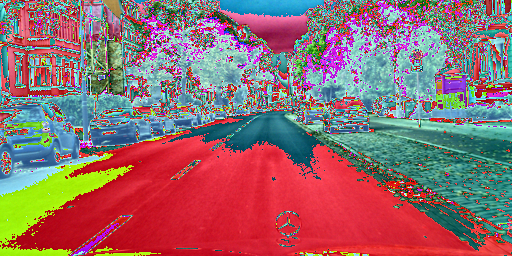

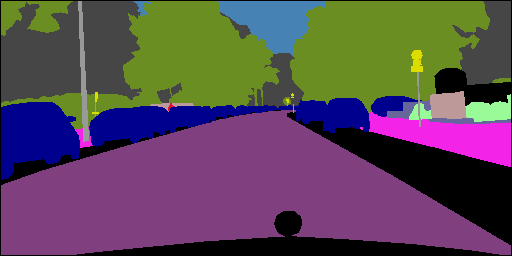

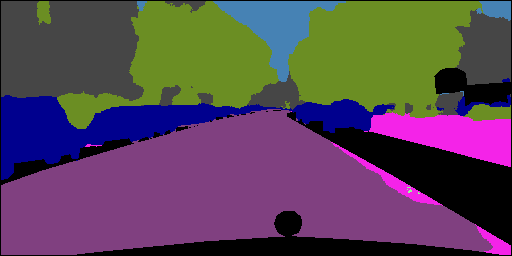

In [ ]:
def createIfNotExist(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def saveModel(model, root, epoch):
    torch.save(model, root + "/r2u_epoch_" + str(epoch) + ".model")

def displayTensorAsImage( tensor ):
    display(transforms.ToPILImage()( tensor ))
    
def preview(outputs, targets, epoch):
    outputs = outputs.cpu()
    targets = targets.cpu()

    values, indices = outputs.max(dim=1)
    targetValues, targetIndices = targets.max(dim=1)

    #set areas with classes that are not be trained on to "unknown" class
    excluded = targetValues < 0.1
    targetIndices[excluded] = size
    indices[excluded] = size

    colorImage = torch.stack([colors[indices, 0 ], colors[indices, 1], colors[indices, 2]], dim=1)
    targetImage = torch.stack([colors[targetIndices, 0 ], colors[targetIndices, 1], colors[targetIndices, 2]], dim=1)

    clear_output(wait=False)
    print(epoch)
    displayTensorAsImage( inputs[0] )
    displayTensorAsImage( targetImage[0] )
    displayTensorAsImage( colorImage[0] )

#init dataset with train data
dst = cityscapes(selection = "train")
trainloader = data.DataLoader(dst, batch_size = 1, num_workers = 10)

size = len(mapping)

colors = torch.tensor([
    [128, 64,128],
    [244, 35,232],
    [ 70, 70, 70],
    [102,102,156],
    [190,153,153],
    [153,153,153],
    [250,170, 30],
    [220,220,  0],
    [107,142, 35],
    [152,251,152],
    [ 70,130,180],
    [220, 20, 60],
    [255,  0,  0],
    [  0,  0,142],
    [  0,  0, 70],
    [  0, 60,100],
    [  0, 80,100],
    [  0,  0,230],
    [119, 11, 32],
    [0,0,0]
]) / 255

modelRoot = "/datasets/finalOptim/"

# loss function
criterion = nn.MSELoss()
# optimizer variable
opt = optim.Adam(model.parameters())
saveEachEpoch = False

createIfNotExist(modelRoot)

try:

    for epoch in range(0, 100):
        if saveEachEpoch:
            saveModel(model, modelRoot, epoch)
            
        for i, (inputs, targets) in enumerate(trainloader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            opt.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            opt.step()  

            if i % 100 == 0:
                preview(outputs, targets, epoch)
                

except KeyboardInterrupt:
    pass
    
torch.save(model, "r2u_optim.model")

Model Evaluation

In [ ]:

model = torch.load(modelRoot + "/r2u_epoch_99.model", map_location=device)
model = model.eval()

In [ ]:
import sklearn.metrics

size = len(mapping)

dice = np.zeros(size)
dice_count = np.zeros(size)
jaccard = np.zeros(size)
jaccard_count = np.zeros(size)
confusion_matrix = np.zeros((size, size))

dst = cityscapes(selection = "val")
trainloader = data.DataLoader(dst, batch_size = 1, num_workers = 10)

with torch.no_grad():
    for i, (inputs, targets) in enumerate(trainloader):
        if i % 100 == 0:
            print(i)
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)

        outputs = outputs.cpu()
        targets = targets.cpu()


        targetValues, targetIndices = targets.max(dim=1)
        values, indices = outputs.max(dim=1)

        excluded = targetValues < 0.1
        targetIndices[excluded] = size
        indices[excluded] = size
        
        flattenTarget = targetIndices.flatten()
        flattenOutput = indices.flatten()
        
        confusion_matrix += sklearn.metrics.confusion_matrix(flattenTarget, flattenOutput, labels=range(size))
        
        for k in range(size):
            targetIsClass = flattenTarget==k
            outputIsClass = flattenOutput==k
            # calculate dice score
            occured = (torch.sum(outputIsClass) + torch.sum(targetIsClass))
            
            #if denominator is 0 => class not in image to be concidered
            if occured != 0:
                dice_count[k] += 1
                dice[k] += torch.sum(flattenOutput[targetIsClass]==k)*2.0 / occured
                
            denominator = torch.sum(torch.logical_or(targetIsClass, outputIsClass))
            
            #if denominator is 0 => class not in image to be concidered
            if denominator != 0:
                jaccard_count[k] += 1
                jaccard[k] += torch.sum(torch.logical_and(targetIsClass, outputIsClass)) / denominator
         
        
dice /= dice_count 
jaccard /= jaccard_count  


In [ ]:
from IPython.display import HTML, display
import tabulate

test = np.array(reduced_mapping)-4
if len(reduced_mapping) != len(mapping):
    stripped_matrix = confusion_matrix[test][:, test]
    stripped_dice = dice[test]
    stripped_jaccard = jaccard[test]
else:
    stripped_matrix = confusion_matrix
    stripped_dice = dice
    stripped_jaccard = jaccard

FP = stripped_matrix.sum(axis=0) - np.diag(stripped_matrix)  
FN = stripped_matrix.sum(axis=1) - np.diag(stripped_matrix)
TP = np.diag(stripped_matrix)
TN = stripped_matrix.sum() - (FP + FN + TP)

SE = np.nan_to_num(TP/(TP+FN))
SP = np.nan_to_num(TN/(TN+FP))
PC = np.nan_to_num(TP/(TP + FP))
F1 = np.nan_to_num(2 * (PC * SE) / (PC + SE))
ACC = (TP+TN)/(TP+FP+FN+TN)


names = [
    "static",
    "dynamic",
    "ground",
    "road",
    "sidewalk",
    "parking",
    "rail track",
    "building",
    "wall",
    "fence",
    "guard rail",
    "bridge",
    "tunnel",
    "pole",
    "polegroup",
    "traffic light",
    "traffic sign",
    "vegetation",
    "terrain",
    "sky",
    "person",
    "rider",
    "car",
    "truck",
    "bus",
    "caravan",
    "trailer",
    "train",
    "motorcycle",
    "bicycle"
]

    
def plot(table):
    display(HTML(tabulate.tabulate(torch.tensor(table), tablefmt='html')))
    
import pandas as pd

names = np.array(names)[test]

size = len(reduced_mapping)

frame = [np.append(names, "**Average"), 
         np.append(SE, np.sum(SE) / size), 
         np.append(SP, np.sum(SP) / size), 
         np.append(ACC, np.sum(ACC) / size), 
         np.append(F1, np.sum(F1) / size), 
         np.append(stripped_dice, np.sum(stripped_dice) / size), 
         np.append(stripped_jaccard, np.sum(stripped_jaccard) / size)]


pd.DataFrame(np.stack(frame, axis=1), columns=["Name","SE","SP","ACC","F1","Dice", "Jaccard"])